# Training food classifier
First, we train a model that can distinguish pictures of food vs. non-food. This will help with the next step of classifying specific cuisines. 1155 images have been manually labeled.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

### Preprocess image data
First we preprocess the image data. For the image augmentation, we rescale the images by 1/255, apply a shear range of 0.2, zoom range of 0.2, and horizontal flip. This is done for both train and validation data.
Next, we create batches of augmented images of size 32. `class_mode` is set to `categorical` since we have multiple classes.

In [2]:
# Set batch size and number of epochs
BATCH_SIZE = 64
EPOCHS = 50

# Create data augmentation instance for train set with ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)


# Create data augmentation instance for validation set with ImageDataGenerator
val_datagen = ImageDataGenerator(
    rescale=1./255)

# Create train generator
train_generator = train_datagen.flow_from_directory(
    directory='images_food-nonfood/train/',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=0
)

# Create validation generator
val_generator = val_datagen.flow_from_directory(
    directory='images_food-nonfood/val/',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=0
)

Found 865 images belonging to 2 classes.
Found 290 images belonging to 2 classes.


### Create model
Load ResNet50 model with pretrained ImageNet weights and add a few new layers to finetune with our dataset. Reduce dimensions of the base model with a global average pooling layer and then add a fully connected layer with 1024 units and ReLU activation. Then create the final layer with the number of classes that is uses softmax activation to make classifications.

In [3]:
# Load ResNet50 model
base_model = ResNet50(include_top=False, weights='imagenet')

# Add new layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Define new model
model = Model(inputs=base_model.input, outputs=predictions)

Freeze the layers in the base model so they don't get overwritten, and then compile the model with Adam optimizer and categorical crossentropy loss.

In [4]:
# Freeze each layer in the model
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Define callbacks to save the best model and stop training early if the validation loss doesn't improve after 10 epochs.

In [5]:
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Calculate steps per epoch
n_steps = train_generator.samples // BATCH_SIZE

# Plot loss
plot_loss = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint = ModelCheckpoint(filepath='food-classifier-train.weights.best.hdf5',
                                save_best_only=True,
                                verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

### Train model

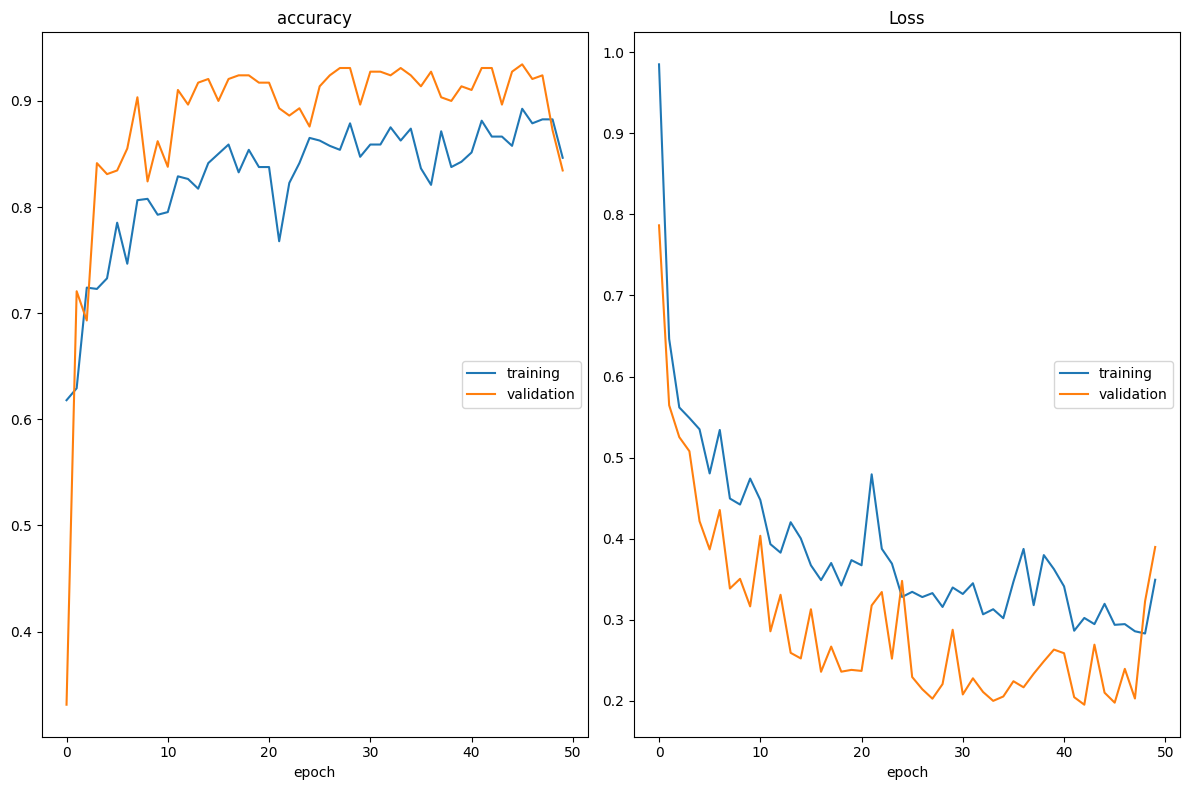

accuracy
	training         	 (min:    0.618, max:    0.893, cur:    0.846)
	validation       	 (min:    0.331, max:    0.934, cur:    0.834)
Loss
	training         	 (min:    0.283, max:    0.985, cur:    0.349)
	validation       	 (min:    0.195, max:    0.786, cur:    0.390)
13/13 [==============================] - 10s 735ms/step - loss: 0.3495 - accuracy: 0.8464 - val_loss: 0.3899 - val_accuracy: 0.8345


In [6]:
# Train model
model.fit(
    train_generator, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=n_steps,
    validation_data=val_generator,
    callbacks=[tl_checkpoint, early_stop, plot_loss]
    )

In [14]:
# Load best weights
model.load_weights('food-classifier-train.weights.best.hdf5')

# Accuracy and loss of best checkpoint
model.evaluate(train_generator)
model.evaluate(val_generator)

5/5 [==============================] - 1s 228ms/step - loss: 0.1954 - accuracy: 0.9310


[0.19537216424942017, 0.931034505367279]

### Save model

In [ ]:
# Save model
model.save('food-classifier_resnet50.h5')